# Using protein and pathologic data to predict neurodegenerative diseases


### Objectives

* Identify protein expression signatures that are correlated with dementia
* Build supervised and unsupervised machine learning models using the protein expression signatures 


### Description of datasets

* The patient info dataset contains demographic (age, sex, race, years of education, etc.) and diagnostic (dementia vs. no dementia) information for 107 unique patients 
* The protein and neuropathology dataset contains expression of 29 proteins from 4 different regions of the brain. For each patient, there are 29X4=116 features.


### Explantion of the original study and data

The  Adult Changes in Thought (ACT) study is a population-based study of brain aging and incident dementia, conducted by Kaiser Permanente Washington Health Research Institute. A specific part of this study, the Aging, Dementia, and Traumatic Brain Injury Study, contains detailed neuropathologic (protein expression) and transcriptomic (RNA expression) characterization of brains from a unique cohort with demographic matched dementia and non-dementia patients. The original aim of the Aging, Dementia, and TBI Study was to study neuropathologic and molecular signatures as a result of severity of TBI. However, the availability of extensive protein and RNA data can potentially be used to identify molecular hallmarks of and to ultimately predict the likelihood of developing dementia. 

* http://aging.brain-map.org/overview/home
* https://help.brain-map.org/display/aging/Documentation

Date 04/15/2022

***

In [1]:
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [2]:
#Patient info data
donor_file_name='data/DonorInformation.csv'

#Protein and neuropathology data
protein_file_name='data/ProteinAndPathologyQuantifications.csv'

# <font color='blue'> Read in and clean donor information</font> 


Donor information file DonorInformation.csv contains basic donor demographic information and diagnosis.

### Diagnosis:
**act_demented**: Any dementia noted during subject's tenure in the ACT study.\
**nincds_arda_diagnosis**: Clinical description of probable or possible Alzheimer's disease based on NINCDS/ADRDA criteria: 0 (no dementia), 1 (probable Alzheimer's disease), 2 (possible Alzheimer's disease), and 3 (dementia, type unknown).)

In [3]:
donor_df=pd.read_csv(donor_file_name)


print('donor_df shape:', donor_df.shape)
print('donor ages:',donor_df['age'].unique())
print('donor nincds_arda_diagnosis:',donor_df['nincds_arda_diagnosis'].unique())
print('donor sexes:',donor_df['sex'].unique())
print('donor act_demented:',donor_df['act_demented'].unique())

donor_df.head()

donor_df shape: (107, 19)
donor ages: ['87' '95-99' '85' '90-94' '100+' '89' '78' '83' '82' '77' '81' '88' '84'
 '86' '79']
donor nincds_arda_diagnosis: ['No Dementia' 'Dementia, Type Unknown' "Possible Alzheimer'S Disease"
 "Probable Alzheimer'S Disease"]
donor sexes: ['M' 'F']
donor act_demented: ['No Dementia' 'Dementia']


donor_id        name    age sex apo_e4_allele  education_years  \
0  326765665  H14.09.078     87   M             N               16   
1  326765656  H14.09.069  95-99   M             N               17   
2  326765654  H14.09.067     85   M             Y               10   
3  467056391  H15.09.103  90-94   F             N               11   
4  309335447  H14.09.010   100+   M             Y               16   

   age_at_first_tbi longest_loc_duration  cerad  num_tbi_w_loc  \
0                 0       Unknown or N/A      0              0   
1                12              1-2 min      2              1   
2                72             < 10 sec      3              1   
3                87             < 10 sec      0              1   
4                 0       Unknown or N/A      3              0   

  dsm_iv_clinical_diagnosis  control_set         nincds_arda_diagnosis  \
0               No Dementia           31                   No Dementia   
1               No Dementia           26                   No Dementia   
2                  Vascular           25        Dementia, Type Unknown   
3               No Dementia           52                   No Dementia   
4  Alzheimer's Disease Type           28  Possible Alzheimer'S Disease   

  ever_tbi_w_loc   race      hispanic act_demented  braak  nia_reagan  
0              N  White  Not Hispanic  No Dementia      1           1  
1              Y  White  Not Hispanic  No Dementia      5           2  
2              Y  White  Not Hispanic     Dementia      4           2  
3              Y  White  Not Hispanic  No Dementia      4           0  
4              N  White  Not Hispanic     Dementia      4           2

### Basic donor info bar chart

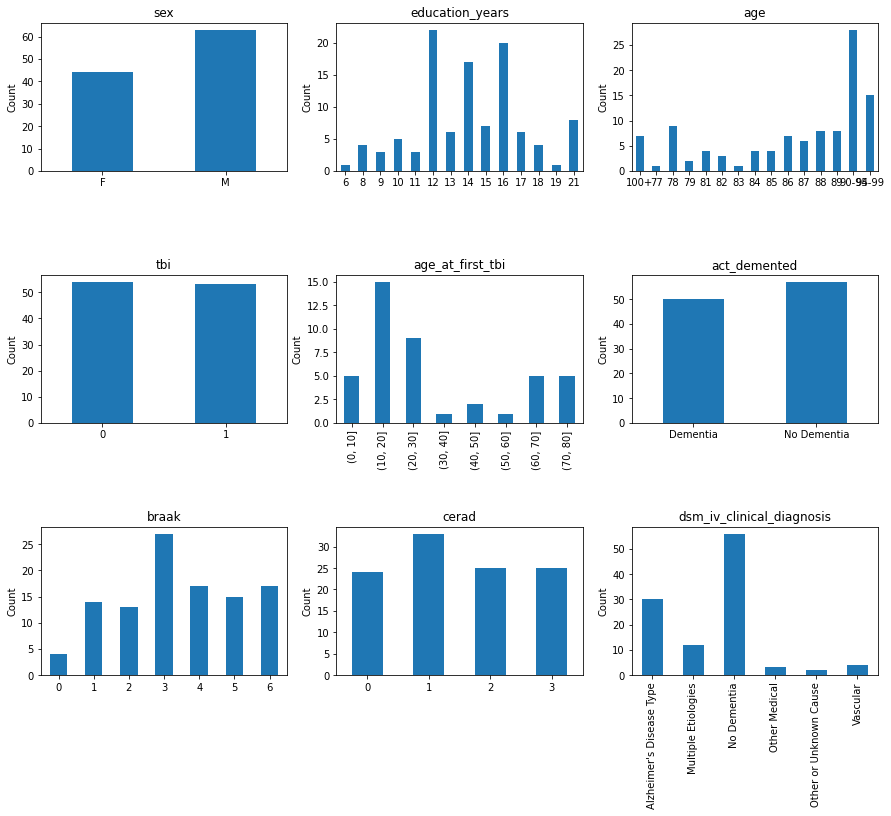

In [4]:
cols =['donor_id','sex','education_years','age_at_first_tbi','age','act_demented','braak','nia_reagan','cerad','dsm_iv_clinical_diagnosis']
df_new = donor_df[cols]
df_new['tbi']= np.where(df_new['age_at_first_tbi']==0, 0, 1)

max_age = df_new.age_at_first_tbi.max()
bins = range(0,max_age,10)
df_new['age_at_first_tbi']= pd.cut(df_new['age_at_first_tbi'],bins)

cols =['sex','education_years','age_at_first_tbi','age','act_demented','braak','nia_reagan','cerad','dsm_iv_clinical_diagnosis']
cols =['sex','education_years','age','tbi','age_at_first_tbi','act_demented','braak','cerad','dsm_iv_clinical_diagnosis']

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.7)
for i, col in enumerate(cols):
    ax = plt.subplot(3,3,i+1)
    
    if ((i==len(cols)-1) or (i==4)):
        df_new[col].value_counts().sort_index().plot(ax= ax, kind = 'bar',rot=90)
    else:
        df_new[col].value_counts().sort_index().plot(ax= ax, kind = 'bar',rot=0)
    ax.set_title(col)
    ax.set_ylabel('Count')

### Clean up donor_df to convert a few columns into numerics

In [5]:
donor_df=pd.read_csv(donor_file_name)



#Change donor age to numeric 
donor_df.loc[donor_df["age"] == "95-99", "age"] = '98'
donor_df.loc[donor_df["age"] == "90-94", "age"] = '92'
donor_df.loc[donor_df["age"] == "100+", "age"] = '100'
donor_df['age']=donor_df['age'].astype('int64')

#Change nincds_arda_diagnosis to numeric
conditions = [
    (donor_df['nincds_arda_diagnosis'] == 'No Dementia'),
    (donor_df['nincds_arda_diagnosis'] == "Probable Alzheimer'S Disease"),
    (donor_df['nincds_arda_diagnosis'] == "Possible Alzheimer'S Disease"),
    (donor_df['nincds_arda_diagnosis'] == "Dementia, Type Unknown")
]

values = [0, 1, 2, 3]

donor_df['nincds_arda_diagnosis_n'] = np.select(conditions, values)
donor_df['nincds_arda_diagnosis'] = donor_df['nincds_arda_diagnosis_n']
donor_df=donor_df.drop(columns=['nincds_arda_diagnosis_n'])


#Change sex to numeric
donor_df['sex'] = np.where(donor_df['sex']=='M', 0, 1)
donor_df['tbi'] = np.where(donor_df['ever_tbi_w_loc']=='Y', 0, 1)

#Change act_demented to numeric
donor_df['act_demented'] = np.where(donor_df['act_demented']=='No Dementia', 0, 1)

print('donor_df shape:', donor_df.shape)
print('donor ages:',donor_df['age'].unique())
print('donor nincds_arda_diagnosis:',donor_df['nincds_arda_diagnosis'].unique())
print('donor sexes:',donor_df['sex'].unique())
print('donor TBI:',donor_df['tbi'].unique())
print('donor act_demented:',donor_df['act_demented'].unique())


donor_df shape: (107, 20)
donor ages: [ 87  98  85  92 100  89  78  83  82  77  81  88  84  86  79]
donor nincds_arda_diagnosis: [0 3 2 1]
donor sexes: [0 1]
donor TBI: [1 0]
donor act_demented: [0 1]


In [6]:
import statsmodels.formula.api as smf

model = smf.ols(formula = 'act_demented ~ tbi + age_at_first_tbi + education_years + age + sex', data=donor_df)
#model = smf.ols(formula = 'act_demented ~ tbi ', data=donor_df)
ols_results = model.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           act_demented   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9624
Date:                Thu, 21 Apr 2022   Prob (F-statistic):              0.445
Time:                        22:43:58   Log-Likelihood:                -74.940
No. Observations:                 107   AIC:                             161.9
Df Residuals:                     101   BIC:                             177.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4046      0.744      0.544      0.588      -1.072       1.881
tbi                 -0.1120      0.139     -0.808      0.421      -0.387       0.163
age_at_first_tbi    -0.0017      0.002     -0.702      0.484      -0.006       0.003
education_years     -0.0247      0.015     -1.607      0.111      -0.055       0.006
age                  0.0053      0.008      0.672      0.503      -0.010       0.021
sex                  0.0742      0.105      0.707      0.481      -0.134       0.283
==============================================================================
Omnibus:                     1070.310   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.820
Skew:                           0.109   Prob(JB):                     0.000605
Kurtosis:                       1.190   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# <font color='blue'>Read in protein and pathology information</font> 

Protein and pathology information file ProteinAndPathologyQuantifications.csv contains 29 protein and pathology quantifications from 4 tissues (under "structure_acronym") for each patient

In [7]:
protein_df=pd.read_csv(protein_file_name)

print('protein_df shape:', protein_df.shape)
print('structure_acronym:',protein_df['structure_acronym'].unique().tolist())
print('number of protein and pathology features:', len(protein_df.columns[4:].tolist()))
print('protein and pathology features:',protein_df.columns[4:].tolist())


protein_df.head()

protein_df shape: (377, 33)
structure_acronym: ['FWM', 'PCx', 'TCx', 'HIP']
number of protein and pathology features: 29
protein and pathology features: ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg', 'ab42_over_ab40_ratio', 'tnf_a_pg_per_mg', 'tau_ng_per_mg', 'il_10_pg_per_mg', 'isoprostane_pg_per_mg', 'il_6_pg_per_mg', 'il_1b_pg_per_mg', 'ptau_over_tau_ratio', 'il_4_pg_per_mg', 'rantes_pg_per_mg', 'ab40_pg_per_mg', 'a_syn_pg_per_mg', 'ifn_g_pg_per_mg', 'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 'mip_1a_pg_per_mg', 'il_7_pg_per_mg', 'ab42_pg_per_mg']


donor_id  donor_name  structure_id structure_acronym  ihc_a_syn  \
0  309335467  H14.09.030         10557               FWM   0.000078   
1  309335480  H14.09.043         10208               PCx   0.000063   
2  309335493  H14.09.056         10557               FWM   0.000064   
3  326765668  H14.09.081         10557               FWM   0.000049   
4  326765668  H14.09.081         10235               TCx   0.000080   

   ihc_tau2_ffpe  ihc_at8_ffpe   ihc_at8  ihc_ptdp_43_ffpe  ihc_a_beta_ffpe  \
0       0.002358      0.001137  0.000110          0.001259         0.008335   
1       0.002762      0.001272  0.000164          0.002354         0.005047   
2       0.003468      0.013787  0.016023          0.001708         0.007365   
3       0.003035      0.001707  0.000137          0.001729         0.004046   
4       0.002088      0.004489  0.000062          0.001513         0.015809   

   ...  il_4_pg_per_mg  rantes_pg_per_mg  ab40_pg_per_mg  a_syn_pg_per_mg  \
0  ...            2.68             15.99        0.736100         0.122288   
1  ...            3.02             24.04        0.669094         0.111962   
2  ...            0.80            129.80        0.736100         0.091084   
3  ...            1.30             15.16        8.995575         0.054076   
4  ...            0.00             17.90       95.931000         0.030000   

   ifn_g_pg_per_mg  mcp_1_pg_per_mg  bdnf_pg_per_mg  mip_1a_pg_per_mg  \
0             1.47            20.78         5.03736              9.38   
1             1.44            40.40         4.95462              8.10   
2             0.54            46.88         5.88409             27.00   
3             0.76            10.34        16.13524              8.06   
4             1.22            21.38         0.03000             10.52   

   il_7_pg_per_mg  ab42_pg_per_mg  
0           11.78      523.292251  
1           45.02       81.493875  
2           15.82      470.734514  
3           24.22      568.368571  
4           23.72      438.863263  

[5 rows x 33 columns]

### Separate protein_df into 4 dateframes, each from a different tissue (structure_acronym). Merge all features into one dataframe

In [8]:
brain_locs = protein_df['structure_acronym'].unique().tolist()


protein_dfs={}
for brain_loc in brain_locs:

    protein_dfs[brain_loc]=protein_df[protein_df['structure_acronym']==brain_loc]
    protein_dfs[brain_loc]=protein_dfs[brain_loc][[protein_dfs[brain_loc].columns[0]]+protein_dfs[brain_loc].columns[4:].tolist()]
    
    protein_dfs[brain_loc].columns=[protein_dfs[brain_loc].columns[0]]+ [x+f'_{brain_loc}' for x in protein_dfs[brain_loc].columns[1:]]


#Combine all features for each patient, keep only patients with data on all 4 "structure_acronym"
merged_all_locs = protein_dfs[brain_locs[0]]

for brain_loc in brain_locs[1:]:
    merged_all_locs=merged_all_locs.merge(protein_dfs[brain_loc], how = 'inner', on = 'donor_id')

features_merged_all_locs=merged_all_locs

for feature in features_merged_all_locs.columns[1:]:
    if len(features_merged_all_locs[feature].unique())==1:
        #print(feature, "is constant", features_merged_all_locs[feature].unique().tolist()[0])
        continue
    else:
        features_merged_all_locs[feature]=features_merged_all_locs[feature].fillna((features_merged_all_locs[feature].mean()))


labels=donor_df[['donor_id','act_demented']].dropna()
merged_all_locs_features_labels=features_merged_all_locs.merge(labels, how = 'inner', on='donor_id').set_index('donor_id')

for feature in merged_all_locs_features_labels.columns:
    if len(merged_all_locs_features_labels[feature].unique())==1:
        print(feature, "is constant", features_merged_all_locs[feature].unique().tolist()[0])
        merged_all_locs_features_labels.drop(feature, axis=1, inplace=True)

merged_all_locs_features_labels

isoprostane_pg_per_mg_FWM is constant nan
il_1b_pg_per_mg_FWM is constant 0.0
il_1b_pg_per_mg_PCx is constant 0.0
il_1b_pg_per_mg_TCx is constant 0.0
isoprostane_pg_per_mg_HIP is constant nan
il_4_pg_per_mg_HIP is constant 0.0


ihc_a_syn_FWM  ihc_tau2_ffpe_FWM  ihc_at8_ffpe_FWM  ihc_at8_FWM  \
donor_id                                                                     
309335467       0.000078           0.002358          0.001137     0.000110   
309335493       0.000064           0.003468          0.013787     0.016023   
326765668       0.000049           0.003035          0.001707     0.000137   
309335497       0.000068           0.001628          0.001869     0.000082   
467056407       0.000159           0.000395          0.001855     0.004874   
...                  ...                ...               ...          ...   
309335490       0.000044           0.001915          0.000991     0.000076   
326765667       0.000049           0.002443          0.002259     0.000051   
326765661       0.000079           0.004107          0.002913     0.000064   
309335471       0.000122           0.002770          0.009523     0.015480   
309335441       0.000059           0.005627          0.001462     0.000244   

           ihc_ptdp_43_ffpe_FWM  ihc_a_beta_ffpe_FWM  ihc_a_beta_FWM  \
donor_id                                                               
309335467              0.001259             0.008335        0.004596   
309335493              0.001708             0.007365        0.017214   
326765668              0.001729             0.004046        0.003868   
309335497              0.001726             0.006456        0.002410   
467056407              0.001481             0.004574        0.011479   
...                         ...                  ...             ...   
309335490              0.001915             0.002476        0.001807   
326765667              0.002084             0.004477        0.000471   
326765661              0.000943             0.009814        0.001751   
309335471              0.001727             0.009425        0.002142   
309335441              0.003170             0.008385        0.003371   

           ihc_iba1_ffpe_FWM  ihc_gfap_ffpe_FWM  ptau_ng_per_mg_FWM  ...  \
donor_id                                                             ...   
309335467           0.029660           0.047025            0.528121  ...   
309335493           0.057172           0.033150            1.543643  ...   
326765668           0.049068           0.043767            1.078323  ...   
309335497           0.090215           0.031460            0.711183  ...   
467056407           0.126324           0.046579            0.758883  ...   
...                      ...                ...                 ...  ...   
309335490           0.048031           0.065117            0.448305  ...   
326765667           0.043545           0.040847            1.160535  ...   
326765661           0.027938           0.010730            1.046318  ...   
309335471           0.045871           0.114841            1.046318  ...   
309335441           0.044044           0.059630            0.447437  ...   

           rantes_pg_per_mg_HIP  ab40_pg_per_mg_HIP  a_syn_pg_per_mg_HIP  \
donor_id                                                                   
309335467                5.0600            1.334037             0.270566   
309335493               29.6800            0.905587             0.372429   
326765668                4.5600            5.170612             0.115779   
309335497               15.5600            0.691362             0.324941   
467056407               13.8100            1.661406             0.037711   
...                         ...                 ...                  ...   
309335490               10.4200            0.842600             0.295440   
326765667               11.7800            0.593988             0.169792   
326765661                8.4600            0.934800             0.196616   
309335471                0.1182          539.532100             0.077730   
309335441                5.9000            0.964013             0.191904   

           ifn_g_pg_per_mg_HIP  mcp_1_pg_per_mg_HIP  bdnf_pg_per_mg_HIP  \
donor_

# <font color='blue'>ML models</font> 

### Logistic Regression

In [9]:
#Logistic regression to classify patients with vs without dementia



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X=merged_all_locs_features_labels[merged_all_locs_features_labels.columns.tolist()[:-1]]
y=merged_all_locs_features_labels[merged_all_locs_features_labels.columns.tolist()[-1]]



X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=RANDOM_STATE)


scaler = StandardScaler()
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.transform(X_test)


clf = LogisticRegression(random_state=RANDOM_STATE).fit(X_train_s, y_train)

y_pred=clf.predict(X_test_s)
print('train_accuracy=',clf.score(X_train_s, y_train))
print('test_accuracy=',clf.score(X_test_s, y_test))
print('--------------classification_report---------------')
print(classification_report(y_test, y_pred, target_names=list(map(str, y.unique().tolist()))))


train_accuracy= 1.0
test_accuracy= 0.8125
--------------classification_report---------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.80      0.67      0.73         6

    accuracy                           0.81        16
   macro avg       0.81      0.78      0.79        16
weighted avg       0.81      0.81      0.81        16



In [10]:
grid_values = {'C':[0.005, 0.01, 0.05, 0.1, 1, 10,100], 'penalty':['l2'] }
clf = LogisticRegression(random_state=RANDOM_STATE)
grid_lr_pre = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy', cv=5)
grid_lr_pre.fit(X_train_s, y_train)
mean_test_scores=grid_lr_pre.cv_results_['mean_test_score'] 

In [11]:
mean_test_scores

array([0.67564103, 0.69230769, 0.67692308, 0.66025641, 0.61025641,
       0.62564103, 0.62564103])

### KNN

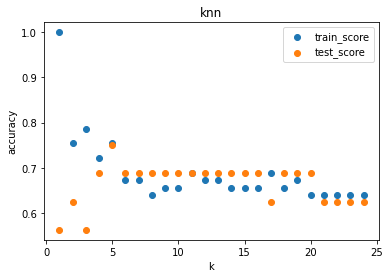

In [12]:
from sklearn.neighbors import KNeighborsClassifier

train_scores =[]
test_scores=[]

k_range = range(1,25,1)
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    # knn_score = "{:.2%}".format(knn.score(X_test, y_test) )
    train_scores.append(knn.score(X_train_s, y_train))
    test_scores.append(knn.score(X_test_s, y_test))

plt.figure();
plt.xlabel('k');
plt.ylabel('accuracy');
plt.scatter(k_range, train_scores, label='train_score');
plt.scatter(k_range, test_scores, label='test_score');
plt.xticks([0,5,10,15,20,25]);
plt.legend();
plt.title('knn');

In [13]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train)

knn_score_train = "{:.2%}".format(knn.score(X_train_s, y_train) )
knn_score_test = "{:.2%}".format(knn.score(X_test_s, y_test) )

print('train score:', knn_score_train)
print('test score:', knn_score_test)

train score: 75.41%
test score: 75.00%


### Random Forest Classifier

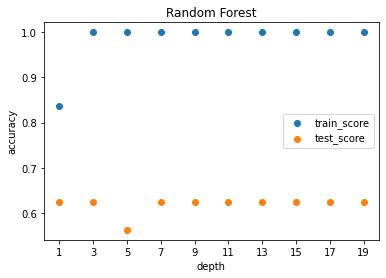

In [14]:
from sklearn.ensemble import RandomForestClassifier

train_scores =[]
test_scores=[]

depth_range=range(1, 20, 2)

for d in depth_range:

    rand = RandomForestClassifier(max_depth=d, random_state=RANDOM_STATE).fit(X_train_s, y_train)

    rand_score_train= "{:.2%}".format(rand.score(X_train_s, y_train) )
    rand_score_test = "{:.2%}".format(rand.score(X_test_s, y_test) )
    
    train_scores.append(rand.score(X_train_s, y_train))
    test_scores.append(rand.score(X_test_s, y_test))

    
    
plt.figure();
plt.xlabel('depth');
plt.ylabel('accuracy');
plt.scatter(depth_range, train_scores, label='train_score');
plt.scatter(depth_range, test_scores, label='test_score');
plt.xticks(depth_range);
plt.legend();
plt.title('Random Forest');

In [15]:
rand = RandomForestClassifier(max_depth=7, random_state=RANDOM_STATE).fit(X_train_s, y_train)

rand_score_train= "{:.2%}".format(rand.score(X_train_s, y_train) )
rand_score_test = "{:.2%}".format(rand.score(X_test_s, y_test) )

print('train score:', rand_score_train)
print('test score:', rand_score_test)

train score: 100.00%
test score: 62.50%


### Decision Tree Classifier

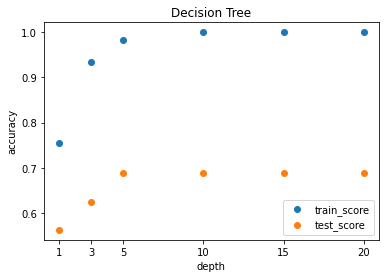

In [16]:
from sklearn.tree import DecisionTreeClassifier

train_scores =[]
test_scores=[]

depth_range=[1, 3, 5, 10, 15, 20]

for d in depth_range:

    clf = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE).fit(X_train_s, y_train)

    clf_score_train= "{:.2%}".format(clf.score(X_train_s, y_train) )
    clf_score_test = "{:.2%}".format(clf.score(X_test_s, y_test) )
    
    train_scores.append(clf.score(X_train_s, y_train))
    test_scores.append(clf.score(X_test_s, y_test))

    
    
plt.figure();
plt.xlabel('depth');
plt.ylabel('accuracy');
plt.scatter(depth_range, train_scores, label='train_score');
plt.scatter(depth_range, test_scores, label='test_score');
plt.xticks(depth_range);
plt.legend();
plt.title('Decision Tree');

In [17]:
clf = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE).fit(X_train_s, y_train)

clf_score_train= "{:.2%}".format(clf.score(X_train_s, y_train) )
clf_score_test = "{:.2%}".format(clf.score(X_test_s, y_test) )

print('train score:', clf_score_train)
print('test score:', clf_score_test)

train score: 98.36%
test score: 68.75%


ihc_tau2_ffpe_HIP 0.3597946859903382
ihc_at8_PCx 0.24822044024701026
ihc_ptdp_43_ffpe_HIP 0.1503179650238474
ihc_a_syn_HIP 0.11587009803921564
ab42_over_ab40_ratio_PCx 0.0635416666666667
isoprostane_pg_per_mg_PCx 0.06225514403292181
vegf_pg_per_mg_TCx 0.0
vegf_pg_per_mg_PCx 0.0
vegf_pg_per_mg_HIP 0.0
vegf_pg_per_mg_FWM 0.0


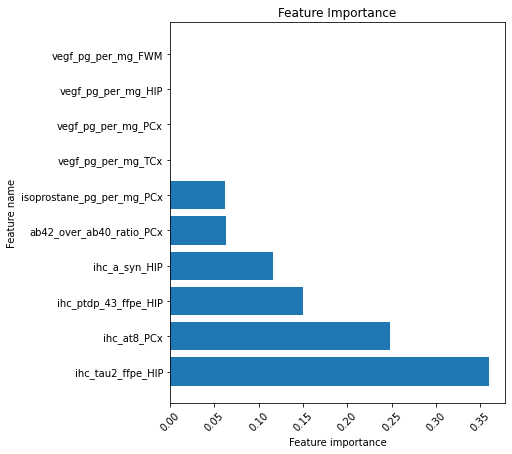

In [18]:
# plot feature importance 
def plot_feature_importances(clf):


    
    imp_features = clf.feature_importances_
    
    feature_names=[]
    importances=[]
    for importance, name in sorted(zip(clf.feature_importances_, X_train.columns),reverse=True)[:10]:
        print(name, importance)
        feature_names.append(name)
        importances.append(importance)

    c_features = len(feature_names)
    
    plt.barh(range(c_features), importances)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
    plt.xticks(rotation = 45)
    plt.title('Feature Importance')


plt.figure(figsize=(6,7))
plot_feature_importances(clf)

plt.show()

### Feature selection based on correlation to outcome variable

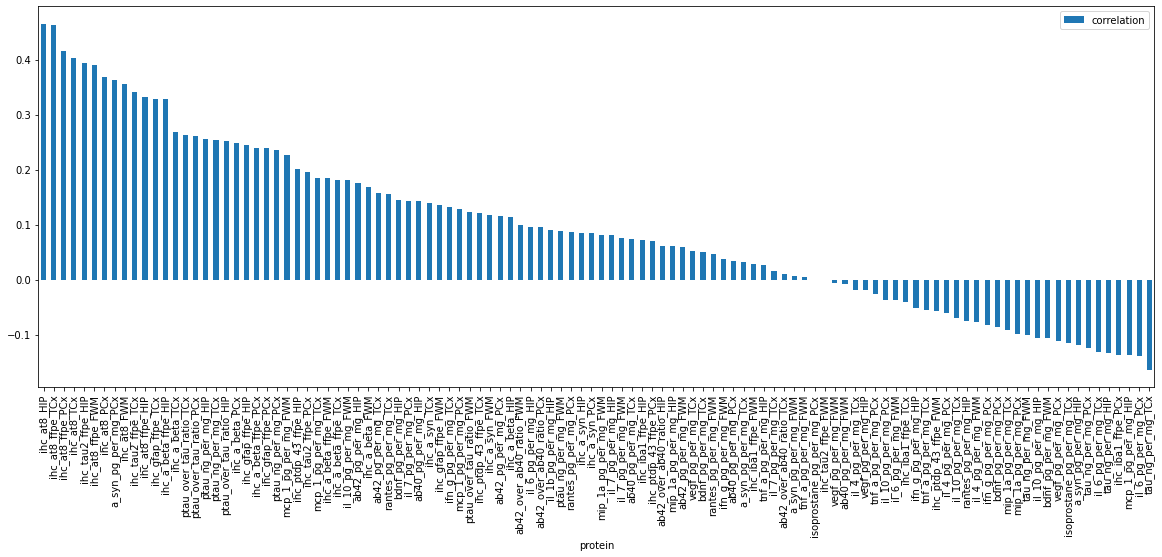

In [19]:
col_names = (merged_all_locs_features_labels.iloc[:,:-1]).columns.values.tolist()

corr = pd.DataFrame(merged_all_locs_features_labels[col_names].corrwith(merged_all_locs_features_labels['act_demented'])).reset_index()
corr = corr.rename({'index':'protein',0:'correlation'}, axis=1)
### plot the correlations
corr_sorted_top_values=corr.sort_values(by='correlation', ascending = False).iloc[:50, :].append(corr.sort_values(by='correlation', ascending = False).iloc[-30:, :])

ax = corr.sort_values(by='correlation', ascending = False).plot.bar(x = 'protein', y = 'correlation', rot = 90, figsize = (20,7) )

In [20]:
#t-test of all features - patients with dementia vs patients without dementia

from scipy import stats



p_value_dfs={}
p_value_dfs_significant_t={}
p_value_significance_value=0.1

corrs=[]
p_values=[]
n_no_dem = []
n_dem = []

no_dementia_pts=merged_all_locs_features_labels[merged_all_locs_features_labels['act_demented']==0]
dementia_pts=merged_all_locs_features_labels[merged_all_locs_features_labels['act_demented']==1]

df=pd.DataFrame()
df['protein_path']=merged_all_locs_features_labels.columns[:-1].tolist()

for feature in merged_all_locs_features_labels.columns[:-1].tolist():

    no_dementia_pts_values = no_dementia_pts[feature].dropna()
    dementia_pts_values = dementia_pts[feature].dropna()
        
    t_test=stats.ttest_ind(no_dementia_pts_values, dementia_pts_values)
    
    corrs.append(t_test[0])
    p_values.append(t_test[1])
    n_no_dem.append(len(no_dementia_pts_values))
    n_dem.append(len(dementia_pts_values))
    
df['n_no_dem']=n_no_dem
df['n_dem']=n_dem
df['p-vale']=p_values
df['corr']=corrs
    
p_value_dfs=df
p_value_dfs_significant_t=df[df['p-vale']<p_value_significance_value].sort_values(by='p-vale')
    

print('                features with p-value < {}'.format(p_value_significance_value))
#print(p_value_dfs_significant_t)
#print('\n','-----------------------------------------------------------------------', '\n')

p_value_dfs_significant_t

                features with p-value < 0.1


protein_path  n_no_dem  n_dem    p-vale      corr
86               ihc_at8_HIP        41     36  0.000020 -4.549862
57          ihc_at8_ffpe_TCx        41     36  0.000023 -4.518006
29          ihc_at8_ffpe_PCx        41     36  0.000171 -3.956391
58               ihc_at8_TCx        41     36  0.000276 -3.816717
84         ihc_tau2_ffpe_HIP        41     36  0.000388 -3.715832
2           ihc_at8_ffpe_FWM        41     36  0.000442 -3.676123
30               ihc_at8_PCx        41     36  0.000988 -3.428968
48       a_syn_pg_per_mg_PCx        41     36  0.001206 -3.365835
3                ihc_at8_FWM        41     36  0.001529 -3.289783
56         ihc_tau2_ffpe_TCx        41     36  0.002348 -3.149586
85          ihc_at8_ffpe_HIP        41     36  0.003207 -3.045228
63         ihc_gfap_ffpe_TCx        41     36  0.003503 -3.015246
88       ihc_a_beta_ffpe_HIP        41     36  0.003606 -3.005336
61            ihc_a_beta_TCx        41     36  0.018456 -2.408898
72   ptau_over_tau_ratio_TCx        41     36  0.021258 -2.352777
44   ptau_over_tau_ratio_PCx        41     36  0.021496 -2.348307
92        ptau_ng_per_mg_HIP        41     36  0.025043 -2.286593
64        ptau_ng_per_mg_TCx        41     36  0.026143 -2.269019
100  ptau_over_tau_ratio_HIP        41     36  0.026808 -2.258711
33            ihc_a_beta_PCx        41     36  0.029647 -2.217090
91         ihc_gfap_ffpe_HIP        41     36  0.032281 -2.181487
32       ihc_a_beta_ffpe_PCx        41     36  0.035633 -2.139688
35         ihc_gfap_ffpe_PCx        41     36  0.036300 -2.131782
36        ptau_ng_per_mg_PCx        41     36  0.038808 -2.103138
22       mcp_1_pg_per_mg_FWM        41     36  0.048409 -2.006492
87      ihc_ptdp_43_ffpe_HIP        41     36  0.080770 -1.770129
28         ihc_tau2_ffpe_PCx        41     36  0.088047 -1.728315

In [21]:
sig_features = p_value_dfs_significant_t['protein_path'].tolist()
all_sig_features_data = merged_all_locs_features_labels[sig_features]
all_sig_features_data

ihc_at8_HIP  ihc_at8_ffpe_TCx  ihc_at8_ffpe_PCx  ihc_at8_TCx  \
donor_id                                                                  
309335467     0.024934          0.006625          0.002332     0.010860   
309335493     0.097795          0.054697          0.038716     0.080423   
326765668     0.025917          0.004489          0.002007     0.000062   
309335497     0.025991          0.000500          0.003726     0.000081   
467056407     0.046106          0.031465          0.004971     0.024467   
...                ...               ...               ...          ...   
309335490     0.029764          0.001409          0.001026     0.000083   
326765667     0.010357          0.017386          0.003113     0.000048   
326765661     0.017859          0.001211          0.002729     0.000086   
309335471     0.056231          0.031764          0.017267     0.081154   
309335441     0.072073          0.005373          0.002934     0.000889   

           ihc_tau2_ffpe_HIP  ihc_at8_ffpe_FWM  ihc_at8_PCx  \
donor_id                                                      
309335467           0.002783          0.001137     0.000401   
309335493           0.012485          0.013787     0.103841   
326765668           0.006376          0.001707     0.004293   
309335497           0.004245          0.001869     0.000178   
467056407           0.018920          0.001855     0.002360   
...                      ...               ...          ...   
309335490           0.002784          0.000991     0.000315   
326765667           0.002411          0.002259     0.000050   
326765661           0.004508          0.002913     0.000089   
309335471           0.004985          0.009523     0.069255   
309335441           0.006623          0.001462     0.000982   

           a_syn_pg_per_mg_PCx  ihc_at8_FWM  ihc_tau2_ffpe_TCx  ...  \
donor_id                                                        ...   
309335467             0.063842     0.000110           0.001832  ...   
309335493             0.221383     0.016023           0.013471  ...   
326765668             0.063328     0.000137           0.002088  ...   
309335497             0.142364     0.000082           0.002209  ...   
467056407             0.041825     0.004874           0.012544  ...   
...                        ...          ...                ...  ...   
309335490             0.064356     0.000076           0.001638  ...   
326765667             0.049193     0.000051           0.001691  ...   
326765661             0.096683     0.000064           0.001554  ...   
309335471             0.096683     0.015480           0.019477  ...   
309335441             0.094482     0.000244           0.004197  ...   

           ptau_ng_per_mg_TCx  ptau_over_tau_ratio_HIP  ihc_a_beta_PCx  \
donor_id                                                                 
309335467            0.980734                 1.772410        0.046151   
309335493            2.637256                 5.355136        0.069108   
326765668            1.688704                 2.667498        0.058136   
309335497            0.522916                 1.123834        0.030464   
467056407            1.632473                 4.170539        0.047967   
...                       ...                      ...             ...   
309335490            0.387651                 1.493196        0.005466   
326765667            0.874461                 1.471315        0.009002   
326765661            0.888779                 1.584258        0.007328   
309335471            2.729506                 3.248154        0.033194   
309335441            0.535010                 4.587877        0.033937   

           ihc_gfap_ffpe_HIP  ihc_a_beta_ffpe_PCx  ihc_gfap_ffpe_PCx  \
donor_id                                                               
309335467           0.051544             0.019101           0.036834   
309335493           0.035280             0.017508           0.026382   
326765668           0.041019            

In [22]:
input_data=merged_all_locs_features_labels

In [23]:
#t-test of all features - patients with dementia vs patients without dementia

from scipy import stats



def get_sig_features(input_data, p_value):
    p_value_dfs={}
    p_value_dfs_significant_t={}
    p_value_significance_value=p_value


    p_values=[]
    n_no_dem = []
    n_dem = []

    no_dementia_pts=input_data[input_data['act_demented']==0]
    dementia_pts=input_data[input_data['act_demented']==1]

    df=pd.DataFrame()
    df['protein_path']=input_data.columns[:-1].tolist()

    for feature in input_data.columns[:-1].tolist():

        no_dementia_pts_values = no_dementia_pts[feature].dropna()
        dementia_pts_values = dementia_pts[feature].dropna()
        
        t_test=stats.ttest_ind(no_dementia_pts_values, dementia_pts_values)
        
        p_values.append(t_test[1])
        n_no_dem.append(len(no_dementia_pts_values))
        n_dem.append(len(dementia_pts_values))
    
    df['n_no_dem']=n_no_dem
    df['n_dem']=n_dem
    df['p-vale']=p_values
    
    p_value_dfs=df
    p_value_dfs_significant_t=df[df['p-vale']<p_value_significance_value]
    

    #print('                features with p-value < {}'.format(p_value_significance_value))
    #print(p_value_dfs_significant_t)
    #print('\n','-----------------------------------------------------------------------', '\n')

    sig_features = p_value_dfs_significant_t['protein_path'].tolist()
    all_sig_features_data = input_data[sig_features]
    
    return all_sig_features_data

In [24]:
#Logistic regression to classify patients with vs without dementia



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

p_values=[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

df=pd.DataFrame()
nums_features=[]
train_accuracies=[]
test_accuracies=[]

for p_value in p_values:

    X=get_sig_features(input_data, p_value)
    y=input_data[input_data.columns.tolist()[-1]]
    


    X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, random_state=RANDOM_STATE)


    scaler = StandardScaler()
    X_train_s=scaler.fit_transform(X_train)
    X_test_s=scaler.transform(X_test)


    clf = LogisticRegression(random_state=RANDOM_STATE, C=1).fit(X_train_s, y_train)

    num_features=len(X.columns)
    train_score=clf.score(X_train_s, y_train)
    test_score = clf.score(X_test_s, y_test)
    
    nums_features.append(num_features)
    train_accuracies.append(train_score)
    test_accuracies.append(test_score)
    
df['p-value'] = p_values
df['num_features'] = nums_features
df['train_accuracy']=  train_accuracies
df['test_accuracy']=  test_accuracies

df

p-value  num_features  train_accuracy  test_accuracy
0    1.000           110        1.000000         0.8125
1    0.500            74        1.000000         0.6250
2    0.100            27        0.918033         0.7500
3    0.050            25        0.868852         0.7500
4    0.010            13        0.786885         0.6250
5    0.005            13        0.786885         0.6250
6    0.001             7        0.819672         0.6250

### Test different classifiers
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier

df=pd.DataFrame()

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "Ridge",
]

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    RidgeClassifier(),
]

train_accuracies=[]
test_accuracies=[]

X=get_sig_features(input_data, 1)
y=merged_all_locs_features_labels[merged_all_locs_features_labels.columns.tolist()[-1]]



X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=RANDOM_STATE)


scaler = StandardScaler()
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.transform(X_test)


for name, clf in zip(names, classifiers):
    
    clf.fit(X_train_s, y_train)
    
    train_score=clf.score(X_train_s, y_train)
    test_score = clf.score(X_test_s, y_test)

    train_accuracies.append(train_score)
    test_accuracies.append(test_score)
    
df['classifier']=names
df['train_accuracy']=  train_accuracies
df['test_accuracy']=  test_accuracies

df

classifier  train_accuracy  test_accuracy
0  Nearest Neighbors        0.754098         0.7500
1         Linear SVM        0.950820         0.6250
2            RBF SVM        1.000000         0.6250
3   Gaussian Process        1.000000         0.5625
4      Decision Tree        1.000000         0.6875
5      Random Forest        1.000000         0.6250
6         Neural Net        1.000000         0.6875
7           AdaBoost        1.000000         0.6250
8        Naive Bayes        0.852459         0.6875
9              Ridge        1.000000         0.5625